This notebook gives an example of how one can analyze different runs in the same database. 
This is for instance relevant if multiple analysis with veiligheidsrendement are made for the same traject.

### Import necessary libraries

In [213]:
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.stats import norm
from peewee import fn
from collections import defaultdict
from vrtool.orm.models import *
from vrtool.orm.orm_controllers import open_database
from vrtool.common.enums import MechanismEnum
from postprocessing.database_analytics import *
from postprocessing.database_access_functions import * 
from postprocessing.generate_output import *

sns.set(style="whitegrid")
colors = sns.color_palette("colorblind", 10)



### Get the runs that are in the database
First we get an overview of the runs in the database

In [242]:
# Give the path to the database
database_path = Path(r'c:\VRM\traject10_voor_handreiking\10-2\database_10-2.sqlite')
# casename = 'new_discounting'
run_list = get_overview_of_runs(database_path)
run_list = [run for run in run_list if run['optimization_type_name']== 'VEILIGHEIDSRENDEMENT']
pd.DataFrame(run_list)
print(run_list)
run_list = run_list[0:4]

[{'id': 1, 'name': 'Basisberekening Veiligheidsrendement', 'discount_rate': 0.03, 'optimization_type': 1, 'optimization_type_name': 'VEILIGHEIDSRENDEMENT'}]


Now, we want to learn which section has the largest effect on the traject failure probability. We use the probability derived from the assessment to: 
* sort sections based on their failure probability
* and find the influence by disabling a section 1 by 1.

[{'id': 4, 'beta': 2.8137579548653977, 'time': 25, 'section_data': 1}, {'id': 11, 'beta': 3.23031140106975, 'time': 25, 'section_data': 2}, {'id': 18, 'beta': 3.2299445866332652, 'time': 25, 'section_data': 3}, {'id': 25, 'beta': 3.832616768473374, 'time': 25, 'section_data': 4}, {'id': 32, 'beta': 3.3502851767232973, 'time': 25, 'section_data': 5}, {'id': 39, 'beta': 2.456817713365429, 'time': 25, 'section_data': 6}, {'id': 46, 'beta': 3.8677191663367947, 'time': 25, 'section_data': 7}, {'id': 53, 'beta': 4.4995002752315, 'time': 25, 'section_data': 8}, {'id': 60, 'beta': 3.9670590598182502, 'time': 25, 'section_data': 9}, {'id': 67, 'beta': 4.446984043895495, 'time': 25, 'section_data': 10}, {'id': 74, 'beta': 3.2772472417186607, 'time': 25, 'section_data': 11}, {'id': 81, 'beta': 3.5221373050993443, 'time': 25, 'section_data': 12}, {'id': 88, 'beta': 4.403643133492083, 'time': 25, 'section_data': 13}, {'id': 95, 'beta': 4.182756929113972, 'time': 25, 'section_data': 14}, {'id': 102,

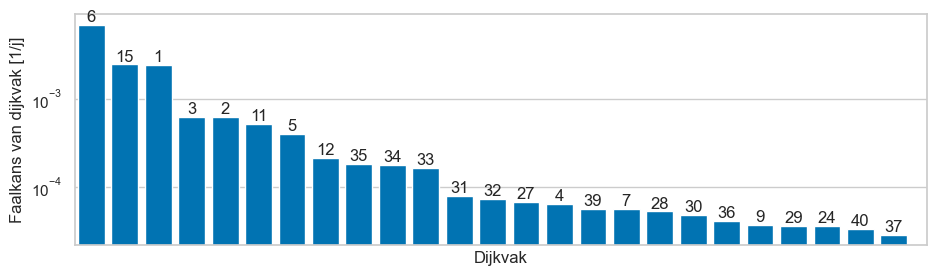

In [243]:
section_reliability_assessment_list = get_section_assessment_results(database_path)

# get beta for each section at 'time'
time = 25

section_reliability_assessment_list = [section for section in section_reliability_assessment_list if section['time'] == time]
print(section_reliability_assessment_list)
# Pf = norm.cdf(-beta)
# beta = -norm.ppf(Pf)
# add Pf to each key, based on beta. Pf = scipy.stats.norm.cdf(-beta)
for section_data in section_reliability_assessment_list:
    section_data['Pf'] = norm.cdf(-section_data['beta'])

# sort the list based on Pf and print sorted list in descending order
section_reliability_assessment_list_sorted_pf = sorted(section_reliability_assessment_list, key=lambda k: k['Pf'], reverse=True)
print(section_reliability_assessment_list_sorted_pf)

# print section ids and Pf
print()
for section in section_reliability_assessment_list_sorted_pf:
    print(f"section_id: {section['section_data']}, Pf: {section['Pf']}")


# write the results to a csv file with the steps, section id, beta and Pf
output_dir = database_path.parent
csv_failure_per_section = output_dir / 'failure_per_section.csv'
with open(csv_failure_per_section, 'w') as f:
    f.write('step, section id, beta, Pf\n')
    for i, section in enumerate(section_reliability_assessment_list_sorted_pf):
        f.write(f"{i+1}, {section['section_data']}, {section['beta']}, {section['Pf']}\n")


top_x = min(25, len(section_reliability_assessment_list_sorted_pf))

# create a bar plot of the Pf values (on the y axis) and the section ids (on the x axis)
# y-axis in log scale
fig, ax = plt.subplots()
# make width dependent on number of sections, so that labels fit
fig.set_size_inches(0.25*len(section_reliability_assessment_list_sorted_pf), 3)
# add title
# ax.set_title(f'Faalkansen van top {top_x} dijkvakken', fontsize=14)
ax.bar(np.arange(0, len(section_reliability_assessment_list_sorted_pf[0:top_x])), [section['Pf'] for section in section_reliability_assessment_list_sorted_pf[0:top_x]], color=colors[0])
ax.set_yscale('log')
# add section_data above each bar
for i, section in enumerate(section_reliability_assessment_list_sorted_pf[0:top_x]):
    ax.text(i, section['Pf'], f"{section['section_data']}", ha='center', va='bottom')
ax.set_xlabel('Dijkvak', fontsize=12)
# hide x-ticks
ax.set_xticks([])
# show only first 25 sections, so set an xlim to the x-axis
ax.set_xlim(-0.5, top_x)
ax.set_ylabel('Faalkans van dijkvak [1/j]', fontsize=12)
# save the figure
fig.savefig(output_dir / 'failure_per_section.png', dpi=300, bbox_inches='tight')
plt.show()


# obtain failure probability traject

In [244]:
pf_eis = get_traject_pf_required(database_path)
print(pf_eis)

0.001


Get initial failure probability of the traject

In [245]:
assessment_results = {mechanism: import_original_assessment(database_path, mechanism) 
                      for mechanism in [MechanismEnum.OVERFLOW, MechanismEnum.PIPING, MechanismEnum.STABILITY_INNER]}

initial_traject_prob_per_mechanism = calculate_traject_probability(assessment_results)
print(initial_traject_prob_per_mechanism)
# print the keys in initial_traject_prob_per_mechanism
print(initial_traject_prob_per_mechanism.keys())
# how many time steps are there in initial_traject_prob_per_mechanism?
n_time_steps = len(initial_traject_prob_per_mechanism[MechanismEnum.OVERFLOW])
print(n_time_steps)
# what are the time steps?
time_steps = initial_traject_prob_per_mechanism[MechanismEnum.OVERFLOW].keys()

# for each time step time, sum the probabilities of each mechanism in initial_traject_prob_per_mechanism, so you get one failure probability in each time step
# we don't know the amount of time steps in advance. Each of the three MechanismEnums has multiple failure probability values for n_time_steps
initial_traject_prob = {time: sum([initial_traject_prob_per_mechanism[mechanism][time] for mechanism in initial_traject_prob_per_mechanism]) for time in time_steps}
print(initial_traject_prob)


{<MechanismEnum.OVERFLOW: 1>: {0: 8.625642325360978e-05, 100: 0.0006495013452424325, 75: 0.0004023108390659708, 50: 0.0002449672824359944, 19: 0.00012929450525212818, 20: 0.00013204201587619678, 25: 0.0001466198539549501}, <MechanismEnum.PIPING: 3>: {0: 0.013009664252130904, 100: 0.02309309486654454, 75: 0.01988226167504592, 50: 0.017171891847211573, 19: 0.014412970462163277, 20: 0.014492556714083116, 25: 0.014899476451536886}, <MechanismEnum.STABILITY_INNER: 2>: {0: 0.00012919708498704274, 100: 0.00012919708498704274, 75: 0.00012919708498704274, 50: 0.00012919708498704274, 19: 0.00012919708498704274, 20: 0.00012919708498704274, 25: 0.00012919708498704274}}
dict_keys([<MechanismEnum.OVERFLOW: 1>, <MechanismEnum.PIPING: 3>, <MechanismEnum.STABILITY_INNER: 2>])
7
{0: 0.013225117760371555, 100: 0.023871793296774014, 75: 0.020413769599098935, 50: 0.01754605621463461, 19: 0.014671462052402448, 20: 0.014753795814946355, 25: 0.01517529339047888}


If we want to see the failure probability per stap we first need to load the original assessment for each mechanism, and then we can compute the reliability for each step during the optimization. 

In [246]:
# get the section ids: section_data in section_reliability_assessment_list
section_ids = [section['section_data'] for section in section_reliability_assessment_list]
section_ids_temp = copy.deepcopy(section_ids) # create a copy to adjust the list in the loop
# get the number of sections
n_sections = len(section_ids)
# get the number of time steps for which a beta is calculated. This is the length of the beta list for the first mechanism in the first section
n_beta = len(assessment_results[MechanismEnum.OVERFLOW][section_ids[0]]['beta'])
print(f"n_sections: {n_sections}, n_beta: {n_beta}") 

t = 25

assessment_results_temp = copy.deepcopy(assessment_results)

section_in_step = ['t_0']
beta_per_step = [initial_traject_prob[t]]

# loop over the different sections
for i in range(1, n_sections+1):
    min_traject_prob = 1
    min_section = 1000

    for section_id in section_ids_temp:
        assessment_results_temp_adj = copy.deepcopy(assessment_results_temp)
        # replace all beta values of section_id with a list containing n_beta times the value 8.0, and keep all values for the other sections the same
        for mechanism in assessment_results_temp.keys():
            # assessment_results_temp_adj = copy.deepcopy(assessment_results_temp)
            assessment_results_temp_adj[mechanism][section_id]['beta'] = [8.0]*n_beta

        # get the traject failure probability for the different mechanisms
        traject_failure_prob_temp_per_mechanism = calculate_traject_probability(assessment_results_temp_adj)
        # print("test", traject_failure_prob_temp_per_mechanism)
        
        traject_prob_temp = {time: sum([traject_failure_prob_temp_per_mechanism[mechanism][time] for mechanism in traject_failure_prob_temp_per_mechanism]) for time in time_steps}
        traject_prob_temp = traject_prob_temp[t]
        # print(traject_prob_temp)
        if traject_prob_temp <= min_traject_prob:
            min_traject_prob = max(traject_prob_temp, pf_eis/10.) # traject probability will not be smaller than Pf_eis/10
            min_section = section_id
    
    print(f"In step {i}, reinforcing section {min_section} leads to the largest probability reduction on traject level. Traject probability: {min_traject_prob}")
    # replace all beta values of min_section with a list containing n_beta times the value 8.0, and keep all values for the other sections the same
    for mechanism in assessment_results_temp.keys():
        assessment_results_temp[mechanism][min_section]['beta'] = [8.0]*n_beta
    
    # add min_section to section_in_step and min_traject_prob to beta_per_step
    section_in_step.append(min_section)
    beta_per_step.append(min_traject_prob)

    # remove min_section from section_ids
    section_ids_temp.remove(min_section)

section_in_step_forward = section_in_step

# save assessment_results_temp tot assessment_results_final
assessment_results_final = assessment_results_temp


n_sections: 44, n_beta: 7
In step 1, reinforcing section 6 leads to the largest probability reduction on traject level. Traject probability: 0.008224906638630987
In step 2, reinforcing section 15 leads to the largest probability reduction on traject level. Traject probability: 0.00576034531261363
In step 3, reinforcing section 1 leads to the largest probability reduction on traject level. Traject probability: 0.0033235055669042233
In step 4, reinforcing section 2 leads to the largest probability reduction on traject level. Traject probability: 0.002710735709455487
In step 5, reinforcing section 3 leads to the largest probability reduction on traject level. Traject probability: 0.002102273678388473
In step 6, reinforcing section 11 leads to the largest probability reduction on traject level. Traject probability: 0.0015814449043216894
In step 7, reinforcing section 5 leads to the largest probability reduction on traject level. Traject probability: 0.001180778881609641
In step 8, reinforc

In [247]:
traject_probability_final = calculate_traject_probability(assessment_results_temp)
print(traject_probability_final)
traject_probability_final_final = {time: sum([traject_probability_final[mechanism][time] for mechanism in traject_probability_final]) for time in time_steps}
traject_probability_final_final = traject_probability_final_final[t]
print(traject_probability_final_final)

{<MechanismEnum.OVERFLOW: 1>: {0: 6.22096057427174e-16, 100: 6.22096057427174e-16, 75: 6.22096057427174e-16, 50: 6.22096057427174e-16, 19: 6.22096057427174e-16, 20: 6.22096057427174e-16, 25: 6.22096057427174e-16}, <MechanismEnum.PIPING: 3>: {0: 2.930988785010413e-14, 100: 2.930988785010413e-14, 75: 2.930988785010413e-14, 50: 2.930988785010413e-14, 19: 2.930988785010413e-14, 20: 2.930988785010413e-14, 25: 2.930988785010413e-14}, <MechanismEnum.STABILITY_INNER: 2>: {0: 2.930988785010413e-14, 100: 2.930988785010413e-14, 75: 2.930988785010413e-14, 50: 2.930988785010413e-14, 19: 2.930988785010413e-14, 20: 2.930988785010413e-14, 25: 2.930988785010413e-14}}
5.924187175763545e-14


Create a plot of the results per dike traject

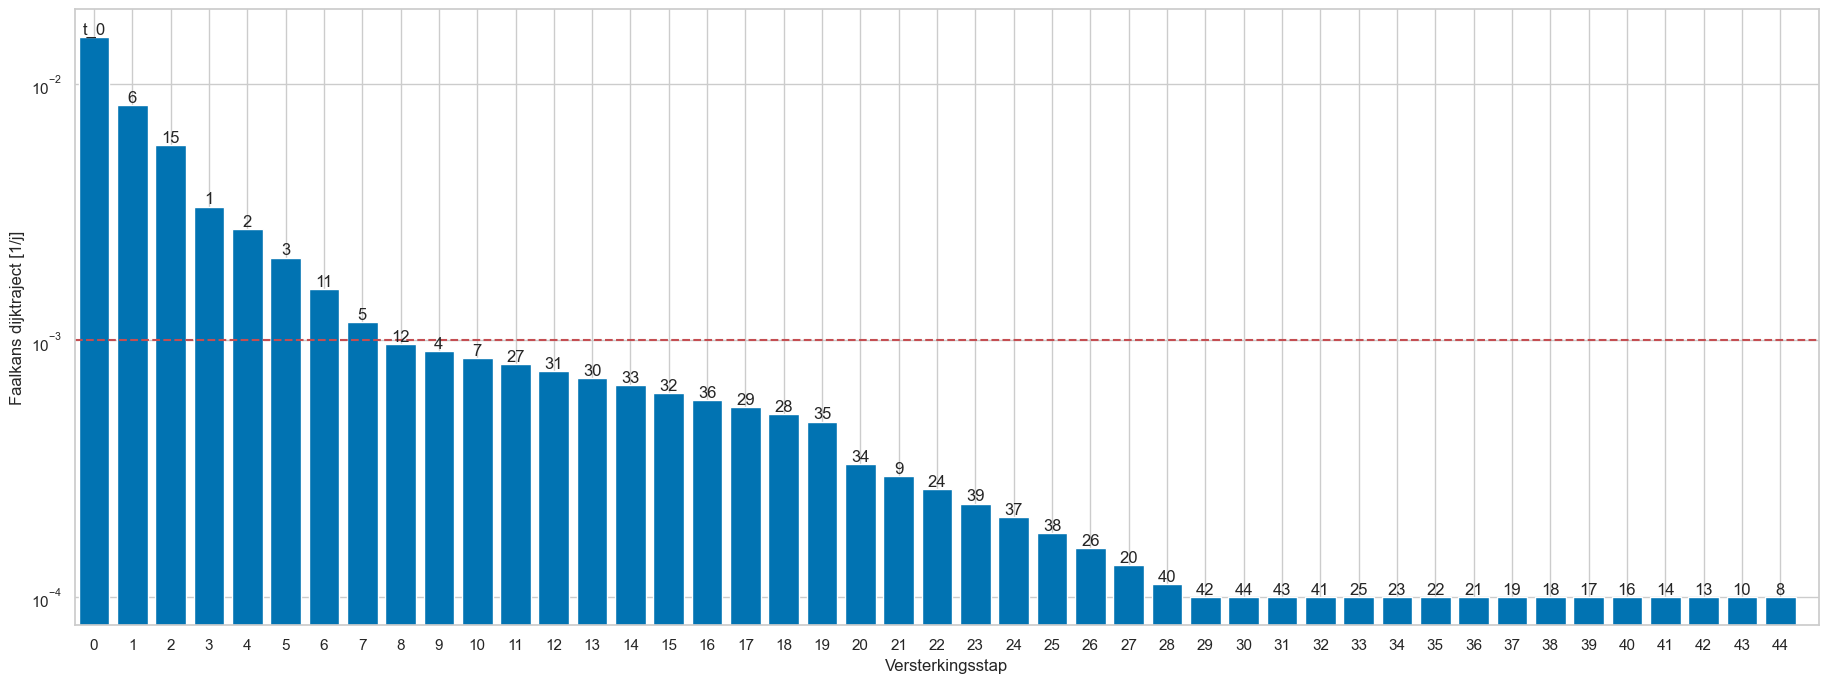

In [249]:
# create a bar plot of the Pf values (on the y axis) and the section ids (on the x axis)
# y-axis in log scale
fig, ax = plt.subplots()
# make width dependent on number of sections, so that labels fit
fig.set_size_inches(0.5*len(section_in_step), 8)
# add title
# ax.set_title('')
ax.bar(np.arange(0, len(section_in_step)), beta_per_step, color=colors[0])
ax.set_yscale('log')
# add section_data above each bar
for i in range(len(beta_per_step)):
    ax.text(i, beta_per_step[i], f"{section_in_step[i]}", ha='center', va='bottom')
ax.set_xlabel('Versterkingsstap')
# xticks should be integers and go from zero to the number of sections
ax.set_xticks(np.arange(0, len(section_in_step)))
ax.set_xlim(-0.5, len(section_in_step))
ax.set_ylabel('Faalkans dijktraject [1/j]')
# add a horizontal line at Pf_eis
ax.axhline(y=pf_eis, color='r', linestyle='--')
# save the figure
fig.savefig(output_dir / 'reinforcement_steps.png', dpi=300, bbox_inches='tight')
plt.show()

# Backwards VNK-approach
Here we assume all dike sections are strengthened (final situation, all betas are 8). And then we switch each dike section back to the initial Pf values. And see what that does to the overall traject probability. 

We want to find the smallest reduction in failure probability and keep that one


In [250]:
# copy the results of the final forward approach (all betas are 8)
assessment_results_final = copy.deepcopy(assessment_results_temp)
# copy the results of the initial assessment
assessment_results_initial = copy.deepcopy(assessment_results)

section_ids_temp = copy.deepcopy(section_ids) # create a copy to adjust the list in the loop

section_in_step_backwards = [f't_end']
beta_per_step = [pf_eis/10.]
starting_traject_prob = pf_eis/1000000000.

# loop over the different sections
for i in range(1, n_sections+1):
    min_traject_prob_reduction = 1
    min_section = 1000

    for section_id in section_ids_temp:
        assessment_results_temp_adj = copy.deepcopy(assessment_results_final)
        # replace all beta values of section_id with a list containing n_beta times the value 8.0, and keep all values for the other sections the same
        for mechanism in assessment_results_final.keys():
            # assessment_results_temp_adj = copy.deepcopy(assessment_results_temp)
            assessment_results_temp_adj[mechanism][section_id]['beta'] = assessment_results_initial[mechanism][section_id]['beta']

        # get the traject failure probability for the different mechanisms
        traject_failure_prob_temp_per_mechanism = calculate_traject_probability(assessment_results_temp_adj)
        # print("test", traject_failure_prob_temp_per_mechanism)
        
        traject_prob_temp = {time: sum([traject_failure_prob_temp_per_mechanism[mechanism][time] for mechanism in traject_failure_prob_temp_per_mechanism]) for time in time_steps}
        traject_prob_temp = traject_prob_temp[t]
        traject_prob_reduction = traject_prob_temp-starting_traject_prob
        if traject_prob_reduction <= min_traject_prob_reduction:
            min_traject_prob_reduction = traject_prob_reduction
            min_traject_prob_temp = traject_prob_temp
            min_section = section_id
        
    min_traject_prob = min_traject_prob_temp

    print(f"In step {i}, 'unreinforcing' section {min_section} leads to the smallest increase on traject level. Traject probability: {min_traject_prob}")
    # replace all beta values of min_section with a list containing n_beta times the value 8.0, and keep all values for the other sections the same
    for mechanism in assessment_results_final.keys():
        assessment_results_final[mechanism][min_section]['beta'] = assessment_results_initial[mechanism][min_section]['beta']
    
    # add min_section to section_in_step and min_traject_prob to beta_per_step
    section_in_step_backwards.append(min_section)
    beta_per_step.append(max(min_traject_prob, pf_eis/10.))

    # remove min_section from section_ids
    section_ids_temp.remove(min_section)

section_in_step_backwards.append('t_0')
beta_per_step.append(initial_traject_prob[t])

In step 1, 'unreinforcing' section 19 leads to the smallest increase on traject level. Traject probability: 2.351345634791433e-06
In step 2, 'unreinforcing' section 21 leads to the smallest increase on traject level. Traject probability: 3.2770699657604794e-06
In step 3, 'unreinforcing' section 16 leads to the smallest increase on traject level. Traject probability: 4.565162262585507e-06
In step 4, 'unreinforcing' section 8 leads to the smallest increase on traject level. Traject probability: 6.377145884321967e-06
In step 5, 'unreinforcing' section 10 leads to the smallest increase on traject level. Traject probability: 8.11980340194467e-06
In step 6, 'unreinforcing' section 13 leads to the smallest increase on traject level. Traject probability: 1.0830642254782075e-05
In step 7, 'unreinforcing' section 23 leads to the smallest increase on traject level. Traject probability: 1.523227834816947e-05
In step 8, 'unreinforcing' section 17 leads to the smallest increase on traject level. Tra

C:\Users\rikkert\AppData\Local\Temp\ipykernel_50432\2290953796.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['end'] + list(range(n_sections, -1, -1)))


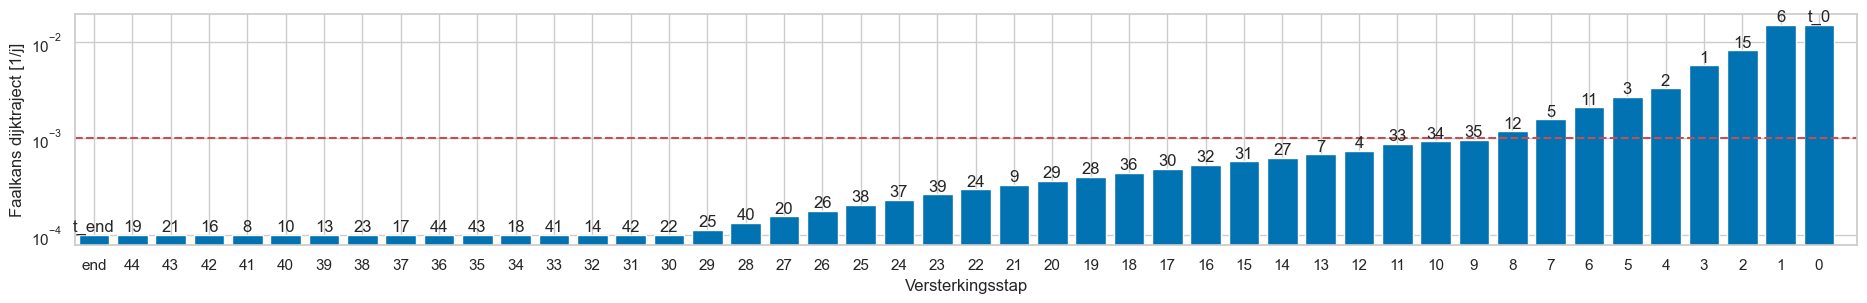

In [251]:
# create a bar plot of the Pf values (on the y axis) and the section ids (on the x axis)
# y-axis in log scale
fig, ax = plt.subplots()
# make width dependent on number of sections, so that labels fit
fig.set_size_inches(0.5*len(section_in_step_backwards), 3)
# add title
# ax.set_title('')
ax.bar(np.arange(0, len(section_in_step_backwards)), beta_per_step, color=colors[0])
ax.set_yscale('log')
# add section_data above each bar
for i in range(1,len(beta_per_step)):
    ax.text(i, beta_per_step[i], f"{section_in_step_backwards[i]}", ha='center', va='bottom')
# add t_end to the first bar, at pf_eis
ax.text(0, pf_eis/10, f"t_end", ha='center', va='bottom')
ax.set_xlabel('Versterkingsstap')
# xticks should go from 'end' and then final step backwards towards  s and go from zero to the number of sections
# location of the x-ticks
ax.set_xticklabels(['end'] + list(range(n_sections, -1, -1)))
ax.set_xticks(range(0, n_sections+2))
# plot the horizontal line at Pf_eis
ax.axhline(y=pf_eis, color='r', linestyle='--')
# ax.set_ylim(1e-6, 1e-2)
ax.set_xlim(-0.5, len(section_in_step_backwards))
ax.set_ylabel('Faalkans dijktraject [1/j]')
# save the figure
fig.savefig(output_dir / 'reinforcement_steps_backwards.png', dpi=300, bbox_inches='tight')
plt.show()


# calculate the "VRindex"
Here we assume all sections are strengthened. And then we stepwise unreinforce only 1 section (bring it back to initial state). We then determine the VRindex: traject_prob-with 1 section back to initial state / (Pf_eis/10 = final traject prob). We sort based on the VRindex: 

In [252]:
# create empty dictionary 'vr_index'
vr_index = []
assessment_results_initial = copy.deepcopy(assessment_results)

# replace all beta values of min_section with a list containing n_beta times the value 8.0, and keep all values for the other sections the same
for mechanism in assessment_results_temp.keys():
    assessment_results_temp[mechanism][min_section]['beta'] = [8.0]*n_beta

for section_id in section_ids:
    # loop through all the sections. assessment_results_final contains all the beta values for each section. We want for section i that the beta values are returned to the initial values assessment_results
    # then calculate traject_probability at time t and divide by pf_eis/10. to get the traject probability reduction
    assessment_results_temp_adj = copy.deepcopy(assessment_results_temp)
    for mechanism in assessment_results_final.keys():
        assessment_results_temp_adj[mechanism][section_id]['beta'] = assessment_results_initial[mechanism][section_id]['beta']
    traject_failure_prob_temp_per_mechanism = calculate_traject_probability(assessment_results_temp_adj)
    traject_prob_temp = {time: sum([traject_failure_prob_temp_per_mechanism[mechanism][time] for mechanism in traject_failure_prob_temp_per_mechanism]) for time in time_steps}
    traject_prob_temp = max(traject_prob_temp[t], pf_eis/10.) # we don't want it to be too small
    traject_prob_reduction = traject_prob_temp/(pf_eis/10.)
    # add the traject probability reduction and the section to the vr_index list
    vr_index.append({'section': section_id, 'vr_index': traject_prob_reduction})

vr_index_sorted = sorted(vr_index, key=lambda k: k['vr_index'], reverse=True)
print(vr_index_sorted)


[{'section': 6, 'vr_index': 70.08689639847425}, {'section': 15, 'vr_index': 24.79746207301773}, {'section': 1, 'vr_index': 24.4830411182013}, {'section': 3, 'vr_index': 6.1907106468742965}, {'section': 2, 'vr_index': 6.1827728220837725}, {'section': 11, 'vr_index': 5.241226802692055}, {'section': 5, 'vr_index': 4.036420045018962}, {'section': 12, 'vr_index': 2.1404118177632983}, {'section': 35, 'vr_index': 1.8086837915401548}, {'section': 34, 'vr_index': 1.7765199159761151}, {'section': 33, 'vr_index': 1.650236768370727}, {'section': 4, 'vr_index': 1.0}, {'section': 7, 'vr_index': 1.0}, {'section': 8, 'vr_index': 1.0}, {'section': 9, 'vr_index': 1.0}, {'section': 10, 'vr_index': 1.0}, {'section': 13, 'vr_index': 1.0}, {'section': 14, 'vr_index': 1.0}, {'section': 16, 'vr_index': 1.0}, {'section': 17, 'vr_index': 1.0}, {'section': 18, 'vr_index': 1.0}, {'section': 19, 'vr_index': 1.0}, {'section': 20, 'vr_index': 1.0}, {'section': 21, 'vr_index': 1.0}, {'section': 22, 'vr_index': 1.0}, 

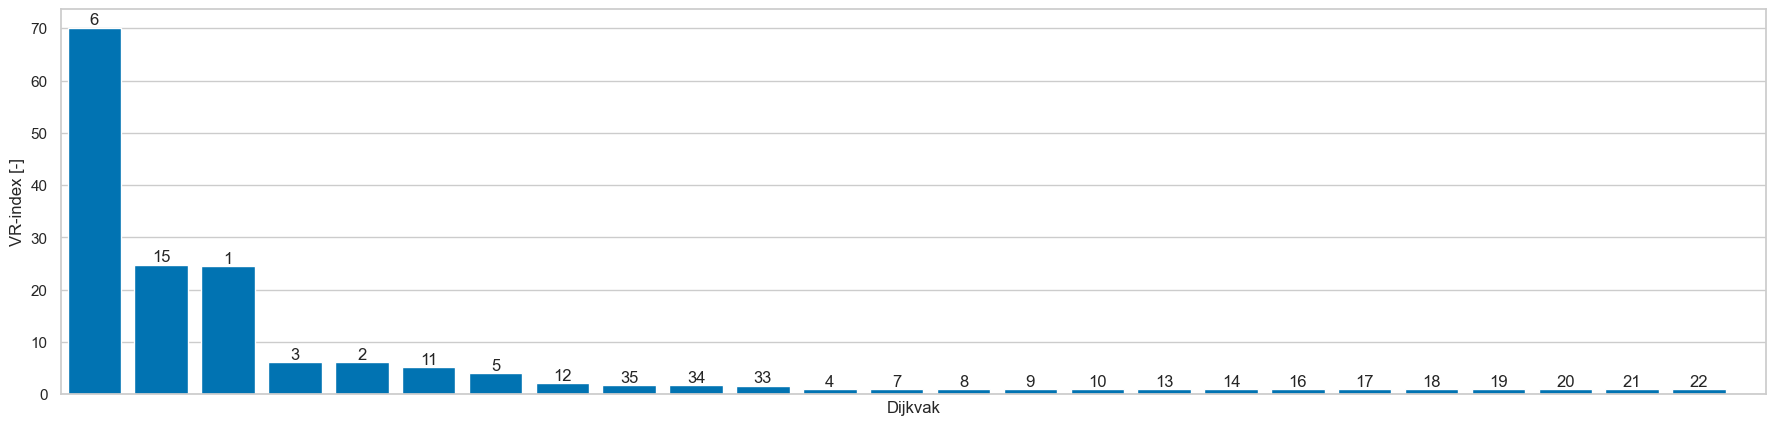

In [253]:
# show only 25
show_only = 25

# make a plot of vr_index_sorted from highest to lowest
fig, ax = plt.subplots()
# make width dependent on number of sections, so that labels fit
fig.set_size_inches(0.5*len(vr_index_sorted), 5)
# add title
# ax.set_title('')
ax.bar(np.arange(0, len(vr_index_sorted[0:show_only])), [section['vr_index'] for section in vr_index_sorted[0:show_only]], color=colors[0])
# add section_data above each bar
for i, section in enumerate(vr_index_sorted[0:show_only]):
    ax.text(i, section['vr_index'], f"{section['section']}", ha='center', va='bottom')
ax.set_xlabel('Dijkvak')
# hide x-ticks
ax.set_xticks([])
# show only first 25 sections, so set an xlim to the x-axis
ax.set_xlim(-0.5, len(vr_index_sorted[0:show_only]))
ax.set_ylabel('VR-index [-]')
# save the figure
fig.savefig(output_dir / 'vr_index.png', dpi=300, bbox_inches='tight')
plt.show()



In [254]:
# make a true dict of the vr_index_sorted list
vr_index_sorted_dict = {section['section']: section['vr_index'] for section in vr_index_sorted}

# print the first 10 vr_index values of the vr_index_sorted_dict, not the sections:
print(list(vr_index_sorted_dict.values())[0:50])

[70.08689639847425, 24.79746207301773, 24.4830411182013, 6.1907106468742965, 6.1827728220837725, 5.241226802692055, 4.036420045018962, 2.1404118177632983, 1.8086837915401548, 1.7765199159761151, 1.650236768370727, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [255]:
# collect the order of sections, based on failure probability, forwards reasoning, backwards reasoning and vr_index. In other words, the section numbers in the order they are presented in the 4 figures.
# combine them in a table and save it to a csv file
section_in_step_forward = [section for section in section_in_step_forward if section != 't_end' and section != 't_0']
section_in_step_backwards = [section for section in section_in_step_backwards if section != 't_end' and section != 't_0']
# get sections from section_reliability_assessment_list_sorted_pf
sections_sorted_by_pf = [section['section_data'] for section in section_reliability_assessment_list_sorted_pf]
print(sections_sorted_by_pf)
print(section_in_step_forward)
print(section_in_step_backwards)
print(list(vr_index_sorted_dict.keys()))
order_of_sections = pd.DataFrame({'pf': sections_sorted_by_pf, 'forward': section_in_step_forward, 'backward': section_in_step_backwards[::-1], 'vr_index': list(vr_index_sorted_dict.keys())})
order_of_sections.to_csv(output_dir / 'order_of_sections.csv', index=False)
print(output_dir / 'order_of_sections.csv')

[6, 15, 1, 3, 2, 11, 5, 12, 35, 34, 33, 31, 32, 27, 4, 39, 7, 28, 30, 36, 9, 29, 24, 40, 37, 38, 26, 20, 25, 22, 42, 14, 41, 18, 17, 43, 44, 23, 13, 10, 8, 16, 21, 19]
[6, 15, 1, 2, 3, 11, 5, 12, 4, 7, 27, 31, 30, 33, 32, 36, 29, 28, 35, 34, 9, 24, 39, 37, 38, 26, 20, 40, 42, 44, 43, 41, 25, 23, 22, 21, 19, 18, 17, 16, 14, 13, 10, 8]
[19, 21, 16, 8, 10, 13, 23, 17, 44, 43, 18, 41, 14, 42, 22, 25, 40, 20, 26, 38, 37, 39, 24, 9, 29, 28, 36, 30, 32, 31, 27, 7, 4, 33, 34, 35, 12, 5, 11, 3, 2, 1, 15, 6]
[6, 15, 1, 3, 2, 11, 5, 12, 35, 34, 33, 4, 7, 8, 9, 10, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44]
c:\VRM\traject10_voor_handreiking\10-2\order_of_sections.csv
